Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 2020/2021  
http://www.fer.unizg.hr/predmet/su

------------------------------

### Laboratorijska vježba 2: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.4  
Zadnji put ažurirano: 22. 10. 2020.*

(c) 2015-2020 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **2. studenog 2020. u 06:00h**

------------------------------

### Upute

Prva laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno** ili u **tandemu**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
import matplotlib.pyplot as plt
import sklearn

from sklearn.linear_model import LinearRegression, RidgeClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, zero_one_loss, log_loss
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification
from numpy.linalg import norm
from numpy import linalg

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None, title=None, figsize=(15, 10)):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    plt.figure(figsize=figsize)
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);
    if title:
        plt.title(title);

## Zadatci

### 1. Linearna regresija kao klasifikator

U prvoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za negativne primjere predviđa vrijednost $1$, dok za pozitivne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [3]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

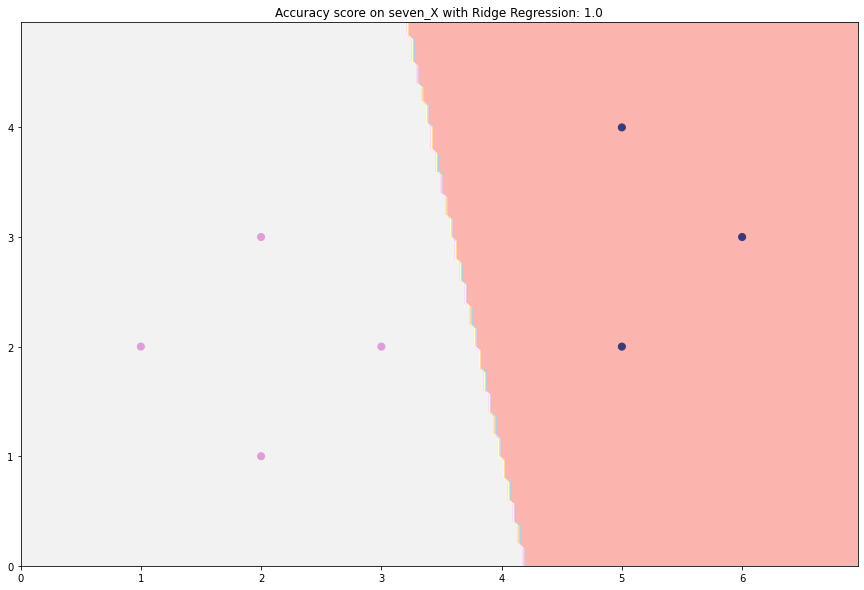

In [4]:
model_ridge = RidgeClassifier(alpha=0).fit(seven_X, seven_y)
predictions = model_ridge.predict(seven_X)
plot_2d_clf_problem(seven_X, seven_y, model_ridge.predict, 
                    "Accuracy score on seven_X with Ridge Regression: {}".format(accuracy_score(seven_y, predictions)))

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

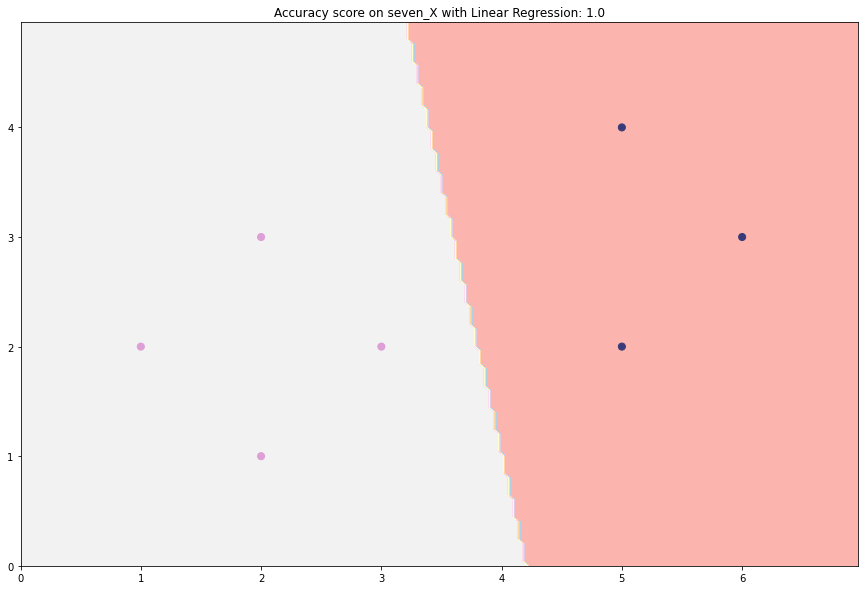

In [5]:
model_reg = LinearRegression().fit(seven_X, seven_y)
predictions_numerical = model_reg.predict(seven_X)
predictions = [1 if x >= 0.5 else 0 for x in predictions_numerical]
plot_2d_clf_problem(seven_X, seven_y, 
                    lambda x: model_reg.predict(x) >= 0.5, 
                    "Accuracy score on seven_X with Linear Regression: {}".format(accuracy_score(seven_y, predictions)))


**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [6]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

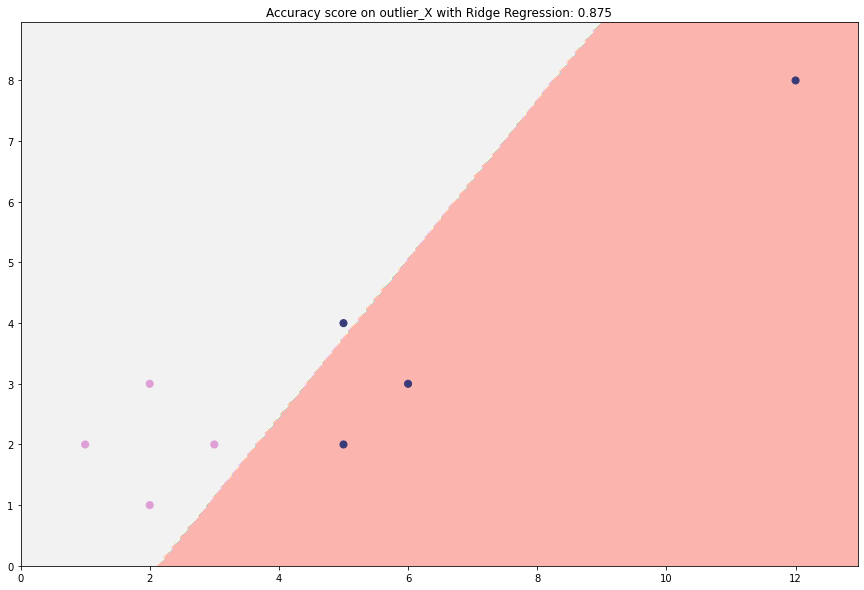

In [7]:
model_ridge = RidgeClassifier(alpha=0).fit(outlier_X, outlier_y)
predictions = model_ridge.predict(outlier_X)
plot_2d_clf_problem(outlier_X, outlier_y, 
                    model_ridge.predict,
                    "Accuracy score on outlier_X with Ridge Regression: {}".format(accuracy_score(outlier_y, predictions)))

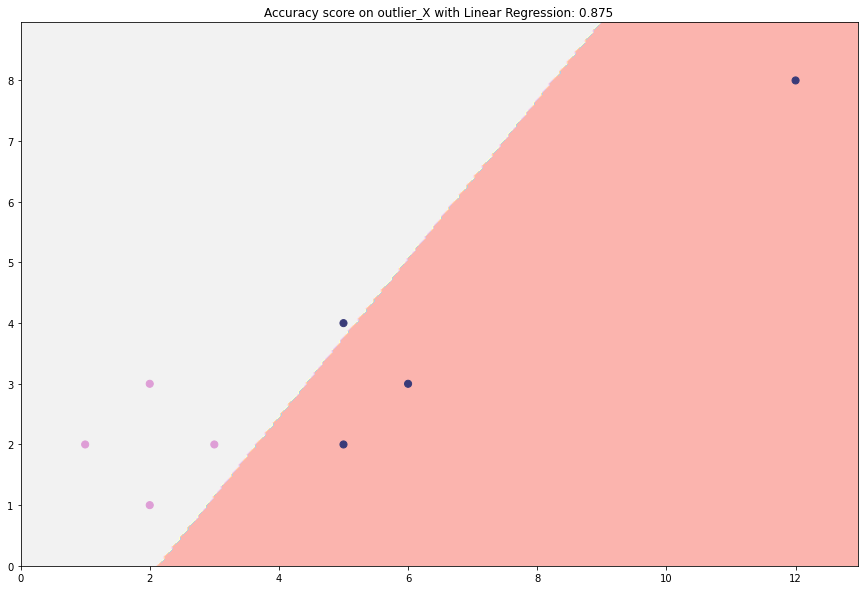

In [8]:
model_reg = LinearRegression().fit(outlier_X, outlier_y)
predictions_numerical = model_reg.predict(outlier_X)
predictions = [1 if x >= 0.5 else 0 for x in predictions_numerical]
plot_2d_clf_problem(outlier_X, outlier_y, 
                    lambda x: model_reg.predict(x) >= 0.5, 
                    "Accuracy score on outlier_X with Linear Regression: {}".format(accuracy_score(outlier_y, predictions)))

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [9]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

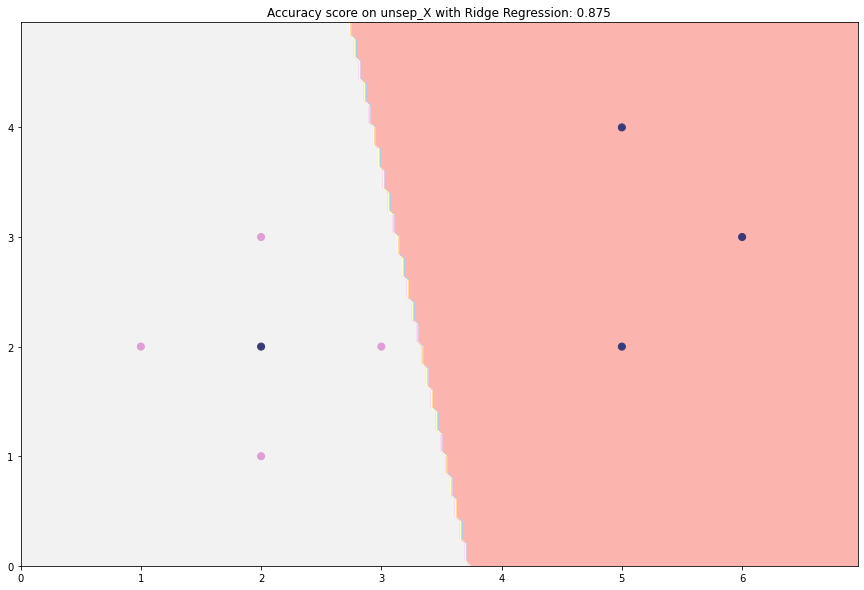

In [10]:
model_ridge = RidgeClassifier(alpha=0).fit(unsep_X, unsep_y)
predictions = model_ridge.predict(unsep_X)
plot_2d_clf_problem(unsep_X, unsep_y, 
                    model_ridge.predict, 
                    "Accuracy score on unsep_X with Ridge Regression: {}".format(accuracy_score(unsep_y, predictions)))

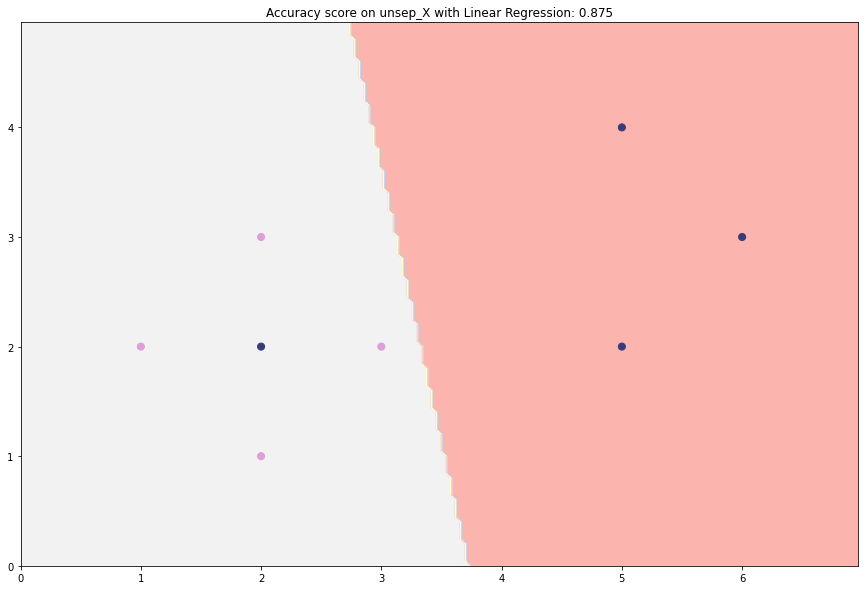

In [11]:
model_reg = LinearRegression().fit(unsep_X, unsep_y)
predictions_numerical = model_reg.predict(unsep_X)
predictions = [1 if x >= 0.5 else 0 for x in predictions_numerical]
plot_2d_clf_problem(unsep_X, unsep_y, 
                    lambda x: model_reg.predict(x) >= 0.5,
                    "Accuracy score on unsep_X with Linear Regression: {}".format(accuracy_score(unsep_y, predictions)))


**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

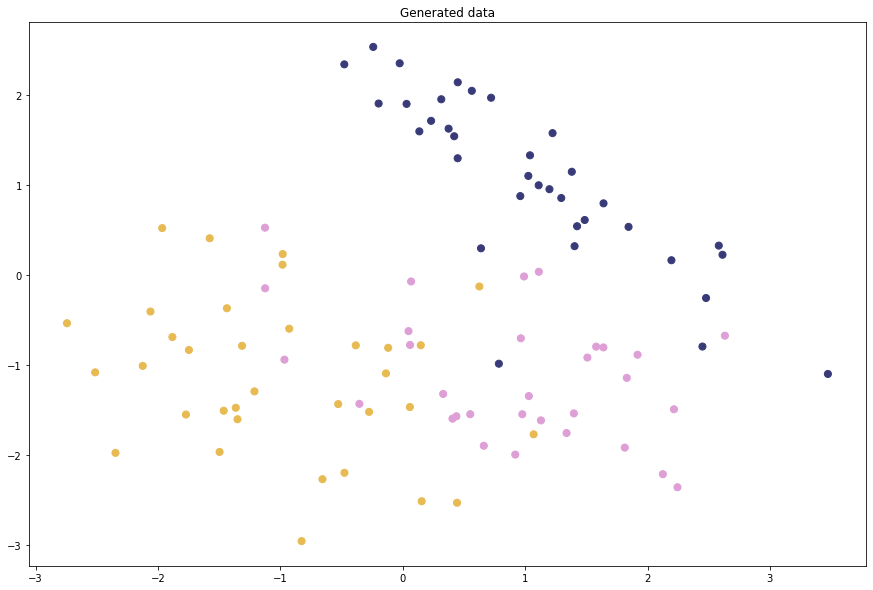

In [12]:
X_generated, y_generated = make_classification(n_features=2, n_classes=3, n_redundant=0, n_clusters_per_class=1)
plot_2d_clf_problem(X_generated, y_generated, title="Generated data")

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

In [13]:
def one_hot_encode(labels, goal_label):
    new_labels = labels.copy()
    for idx in range(labels.shape[0]):
        if new_labels[idx] == goal_label:
            new_labels[idx] = 1
        else:
            new_labels[idx] = 0
    return new_labels

def predict(X):
    predictions = dict()
    final_predictions = np.zeros(shape=X.shape[0])
    for idx, model in enumerate(models):
        predictions[idx] = model.predict(X)
    for idx in range(X.shape[0]):
        predicts_raw = []
        predicts_index = []
        label = -1
        for key in predictions.keys():
            predicts_raw.append(predictions[key][idx])
            predicts_index.append(1 if predictions[key][idx] >= 0.5 else 0)
        for i in range(len(predicts_raw)):
            if predicts_index[i] == 1:
                if label != -1:
                    label = i if predicts_raw[i] > predicts_raw[label] else label
                else:
                    label = i
        if label == -1:
            max_raw = max(predicts_raw)
            label = predicts_raw.index(max_raw)
        final_predictions[idx] = label
    return final_predictions

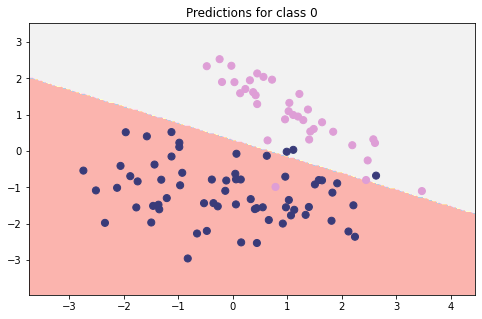

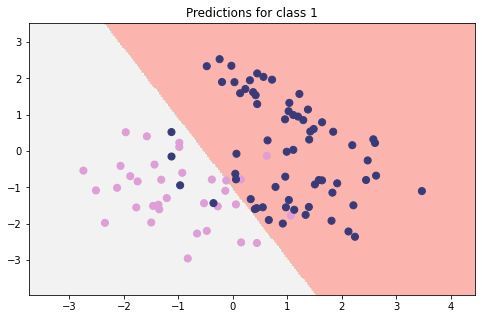

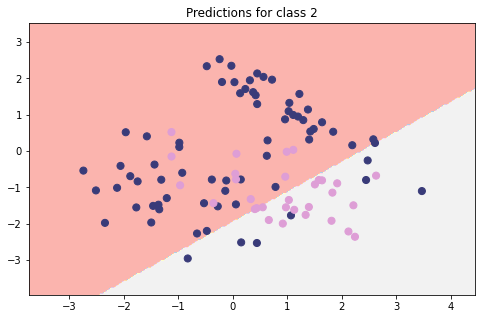

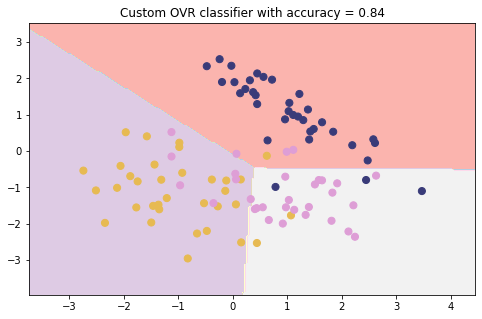

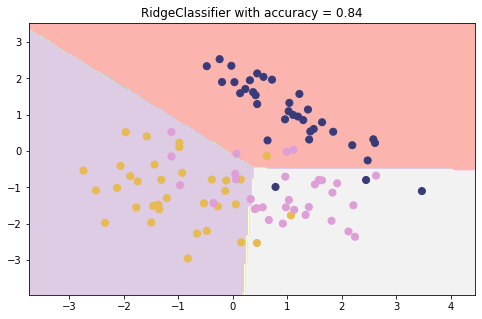

In [14]:
labels = [0, 1, 2]
models = []
for goal_label in labels:
    y_OHE = one_hot_encode(y_generated, goal_label)
    model = LinearRegression().fit(X_generated, y_OHE)
    models.append(model)
    plot_2d_clf_problem(X_generated, y_OHE, lambda x: model.predict(x) >= 0.5, 
                        "Predictions for class {}".format(goal_label), figsize=(8,5))
    
predictions = predict(X_generated)
plot_2d_clf_problem(X_generated, y_generated, lambda x: predict(x),
                   "Custom OVR classifier with accuracy = {}".format(accuracy_score(y_generated, predictions)), 
                    figsize=(8, 5))
    
model = RidgeClassifier(alpha=0).fit(X_generated, y_generated)
predictions = model.predict(X_generated)
plot_2d_clf_problem(X_generated, y_generated, model.predict,
                    "RidgeClassifier with accuracy = {}".format(accuracy_score(y_generated, predictions)), 
                    figsize=(8, 5))

### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

In [15]:
def sigmoid(x, a=1):
    return 1/(1 + np.exp(-a*x))

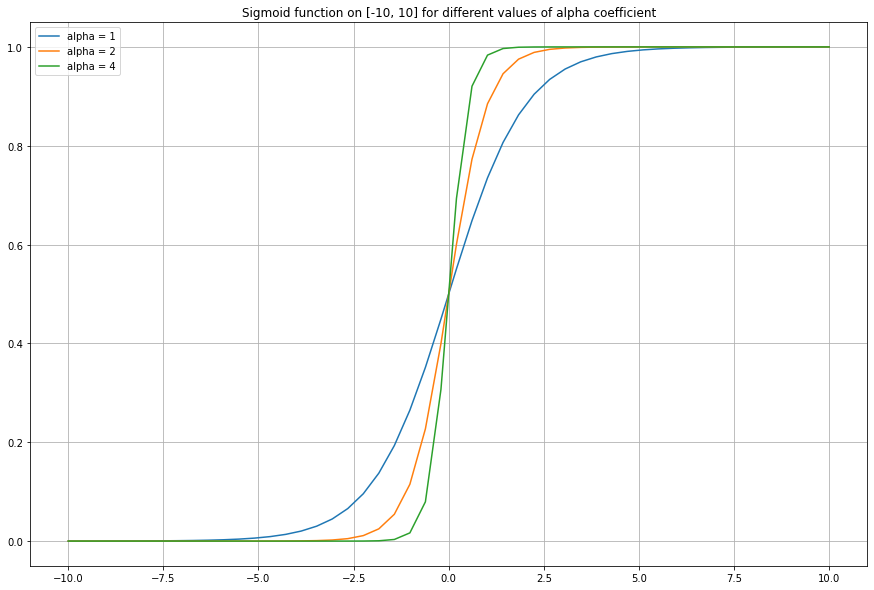

In [16]:
x = np.linspace(-10, 10)
plt.figure(figsize=(15, 10))
for a in (1, 2, 4):
    y = sigmoid(x, a)
    plt.plot(x, y, label="alpha = {}".format(a))
plt.grid()
plt.title("Sigmoid function on [-10, 10] for different values of alpha coefficient")
plt.legend();

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [17]:
def lr_h(X, w):
    return sigmoid(np.dot(X, w))

def cross_entropy_loss(X, y, w):
    h = lr_h(X, w)
    return -y*np.log(h) - (1 - y)*np.log(1-h)

def cross_entropy_error(X, y, w):
    return np.mean(cross_entropy_loss(X, y, w))

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    w = np.zeros(X.shape[1])
    w_on_epoch = []
    epoch = 0
    error = cross_entropy_error(X, y, w)
    prev_error = cross_entropy_error(X, y, w)
    while epoch < max_iter and error >= epsilon:
        delta_w = np.zeros(X.shape[1] -1)
        delta_w0 = 0
        for i in range(X.shape[0]):
            h = lr_h(X[i, :], w)
            delta_w0 = delta_w0 - (h - y[i])*X[i, 0]
            delta_w = delta_w - (h - y[i])*X[i, 1:]
        w[0] = w[0] + eta*delta_w0
        w[1:] = w[1:]*(1 - eta*alpha) + eta*delta_w
        w_on_epoch.append(w.copy())
        tmp_error = cross_entropy_error(X, y, w)
        error = np.abs(tmp_error - prev_error)
        prev_error = tmp_error
        epoch += 1
    print("Treniranje završeno na {}. epohi.".format(epoch+1))
    if trace:
        return w, w_on_epoch
    return w

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

Treniranje završeno na 948. epohi.
Dobivene težine su: [ 4.45449454 -1.71089242  0.68413507]


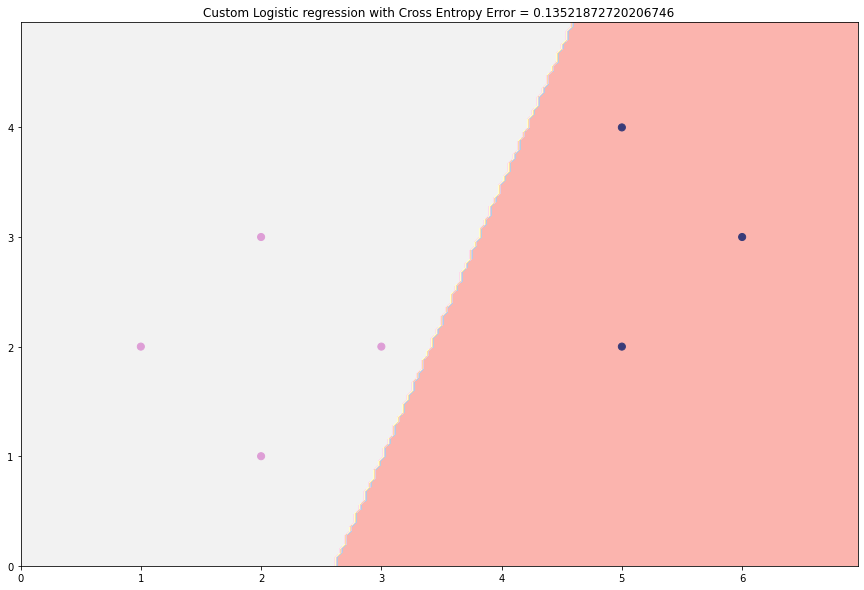

In [18]:
seven_X_transformed = PolynomialFeatures(1).fit_transform(seven_X)
w = lr_train(seven_X_transformed, seven_y)
print("Dobivene težine su: {}".format(w))
plot_2d_clf_problem(seven_X, seven_y, 
                    lambda X: lr_h(PolynomialFeatures(1).fit_transform(X), w) > (1 - lr_h(PolynomialFeatures(1).fit_transform(X), w)),
                   "Custom Logistic regression with Cross Entropy Error = {}".format(cross_entropy_error(seven_X_transformed, seven_y, w)))

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

Treniranje završeno na 948. epohi.
Treniranje završeno na 1143. epohi.
Treniranje završeno na 948. epohi.
Treniranje završeno na 512. epohi.
Treniranje završeno na 379. epohi.


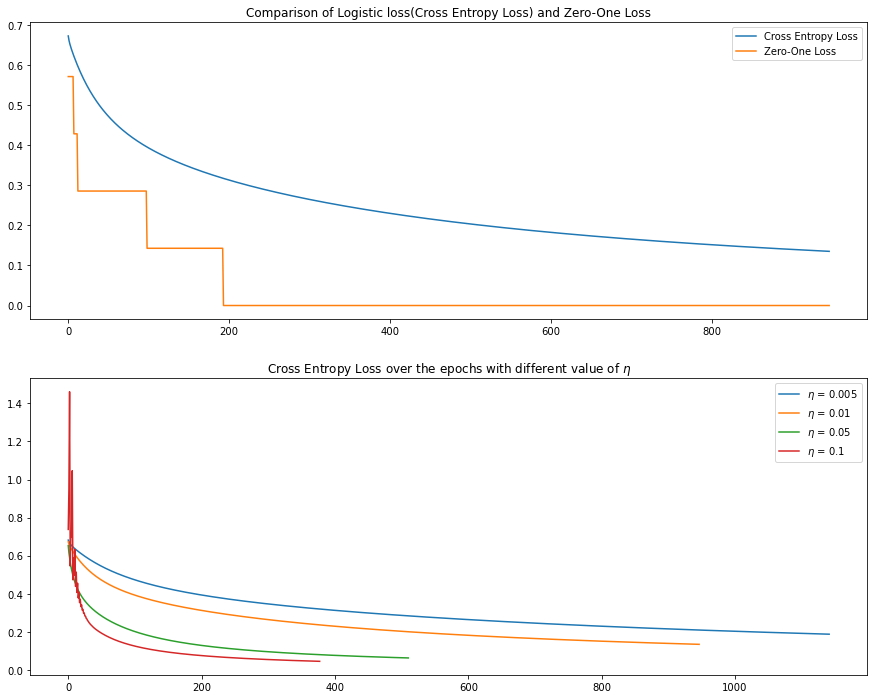

In [19]:
w, w_epochs = lr_train(seven_X_transformed, seven_y, trace=True)

ce_losses = []
zo_losses = []
for w_i in w_epochs:
    h = lr_h(seven_X_transformed, w_i)
    preds = [1 if x > (1 - x) else 0 for x in h]
    ce_losses.append(cross_entropy_error(seven_X_transformed, seven_y, w_i))
    zo_losses.append(zero_one_loss(seven_y, preds))
    
plt.figure(figsize=(15,12))
plt.subplot(2, 1, 1)
plt.plot(range(len(w_epochs)), ce_losses, label='Cross Entropy Loss')
plt.plot(range(len(w_epochs)), zo_losses, label='Zero-One Loss')
plt.title("Comparison of Logistic loss(Cross Entropy Loss) and Zero-One Loss")
plt.legend();

plt.subplot(2, 1, 2)
for eta in (0.005, 0.01, 0.05, 0.1):
    w, w_epochs = lr_train(seven_X_transformed, seven_y, eta=eta, trace=True)
    ce_losses = []
    for w_i in w_epochs:
        ce_losses.append(cross_entropy_error(seven_X_transformed, seven_y, w_i))
    plt.plot(range(len(w_epochs)), ce_losses, label="$\eta$ = {}".format(eta))
plt.title("Cross Entropy Loss over the epochs with different value of $\eta$")
plt.legend();


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

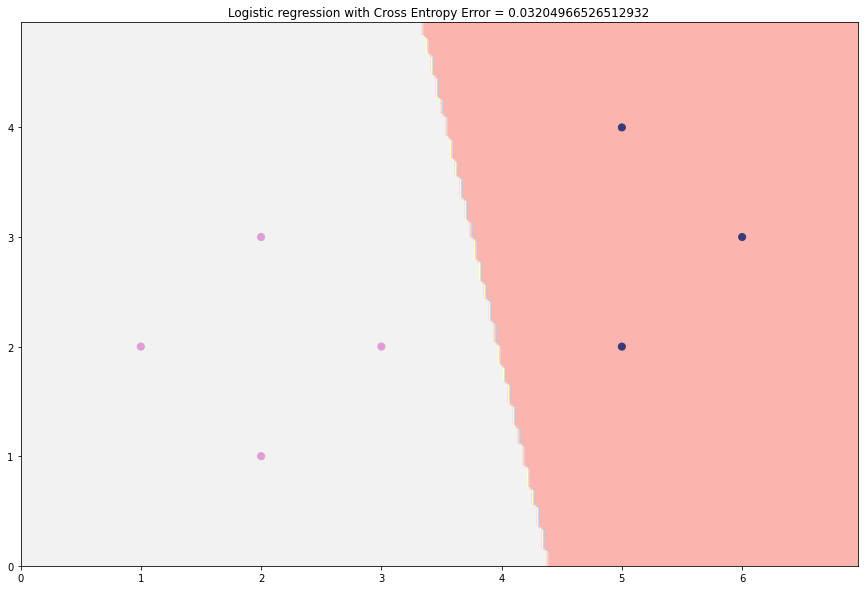

In [20]:
model_logistic = LogisticRegression(C=10).fit(seven_X_transformed, seven_y)
probs = model_logistic.predict_proba(seven_X_transformed)
ce_error = log_loss(seven_y, probs)
plot_2d_clf_problem(seven_X, seven_y, lambda X: model_logistic.predict(PolynomialFeatures(1).fit_transform(X)),
                   "Logistic regression with Cross Entropy Error = {}".format(ce_error))

### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier` iz prvog zadatka. Prikažite granicu između klasa.

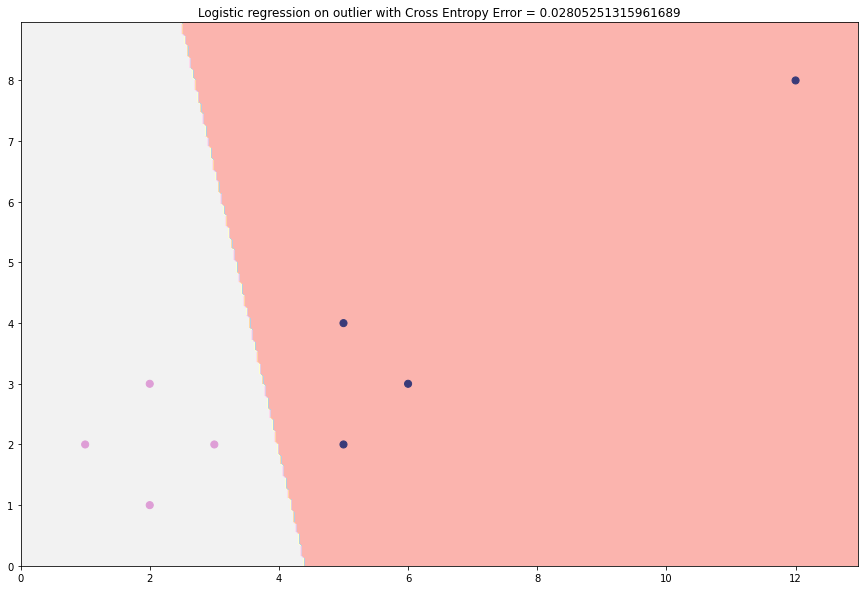

In [21]:
outlier_X_transformed = PolynomialFeatures(1).fit_transform(outlier_X)
model = LogisticRegression(C=10).fit(outlier_X_transformed, outlier_y)
probs = model.predict_proba(outlier_X_transformed)
ce_error = log_loss(outlier_y, probs)
plot_2d_clf_problem(outlier_X, outlier_y, lambda X: model.predict(PolynomialFeatures(1).fit_transform(X)),
                   "Logistic regression on outlier with Cross Entropy Error = {}".format(ce_error))

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

Treniranje završeno na 948. epohi.


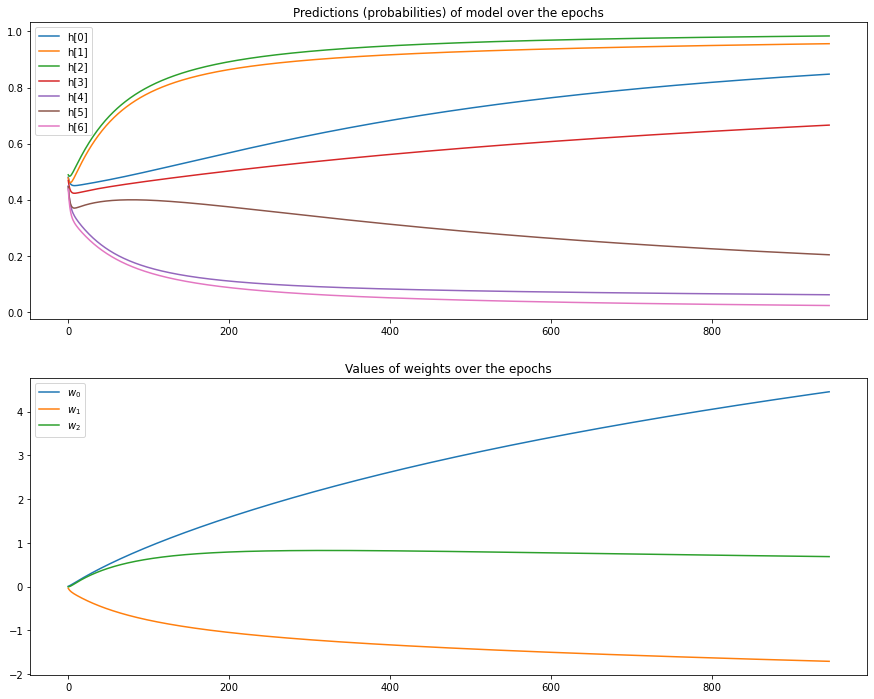

In [22]:
w, w_epochs = lr_train(seven_X_transformed, seven_y, trace=True)

num_of_inputs = seven_X_transformed.shape[0]
num_of_features = w.shape[0]
predictions = [[] for x in range(num_of_inputs)]
weights = [[] for x in range(num_of_features)]

for w_i in w_epochs:
    h = lr_h(seven_X_transformed, w_i)
    for i in range(num_of_inputs):
        predictions[i].append(h[i])
    for i in range(num_of_features):
        weights[i].append(w_i[i])

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
for i in range(num_of_inputs):
    plt.plot(range(len(w_epochs)), predictions[i], label="h[{}]".format(i))
plt.legend()
plt.title("Predictions (probabilities) of model over the epochs")

plt.subplot(2, 1, 2)
for i in range(num_of_features):
    plt.plot(range(len(w_epochs)), weights[i], label="$w_{}$".format(i))
plt.legend()
plt.title("Values of weights over the epochs"); 

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep` iz prvog zadatka.

Treniranje završeno na 455. epohi.


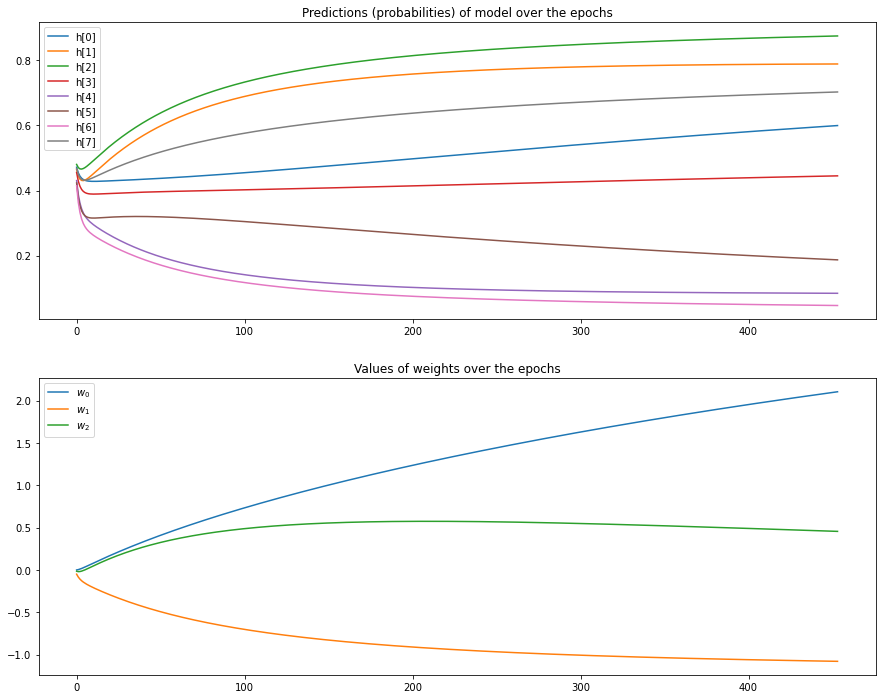

In [23]:
unsep_X_transformed = PolynomialFeatures(1).fit_transform(unsep_X)
w, w_epochs = lr_train(unsep_X_transformed, unsep_y, trace=True)

num_of_inputs = unsep_X_transformed.shape[0]
num_of_features = w.shape[0]
predictions = [[] for x in range(num_of_inputs)]
weights = [[] for x in range(num_of_features)]

for w_i in w_epochs:
    h = lr_h(unsep_X_transformed, w_i)
    for i in range(num_of_inputs):
        predictions[i].append(h[i])
    for i in range(num_of_features):
        weights[i].append(w_i[i])

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
for i in range(num_of_inputs):
    plt.plot(range(len(w_epochs)), predictions[i], label="h[{}]".format(i))
plt.legend()
plt.title("Predictions (probabilities) of model over the epochs")

plt.subplot(2, 1, 2)
for i in range(num_of_features):
    plt.plot(range(len(w_epochs)), weights[i], label="$w_{}$".format(i))
plt.legend()
plt.title("Values of weights over the epochs");

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

Treniranje završeno na 948. epohi.
Treniranje završeno na 805. epohi.
Treniranje završeno na 406. epohi.
Treniranje završeno na 5. epohi.


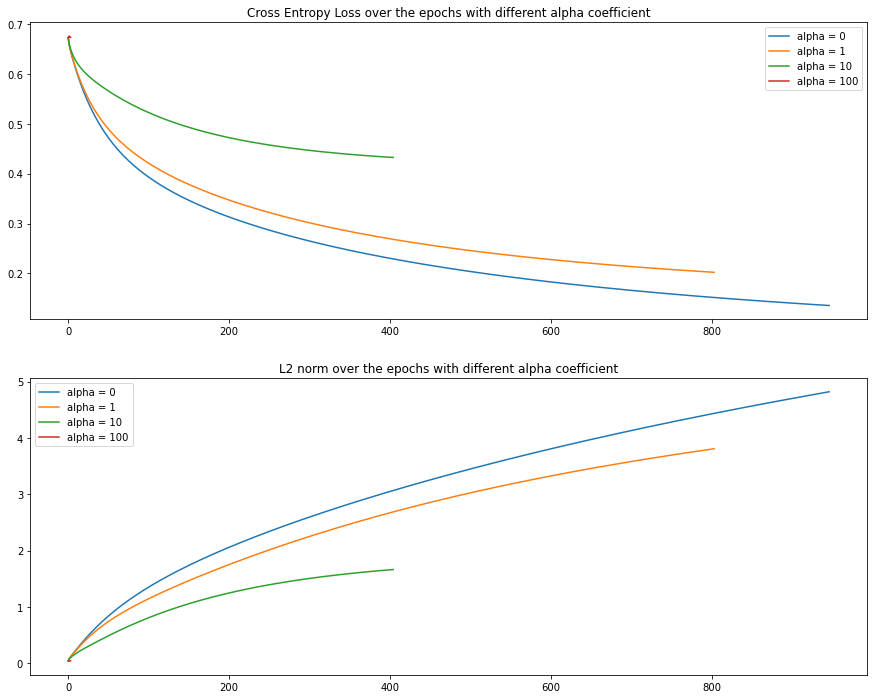

In [24]:
alphas = [0, 1, 10, 100]
num_of_alphas = len(alphas)
n_epochs = []
losses = [[] for x in range(num_of_alphas)]
norms = [[] for x in range(num_of_alphas)]

for idx, alpha in enumerate(alphas):
    w, w_epochs = lr_train(seven_X_transformed, seven_y, alpha=alpha, trace=True)
    n_epochs.append(len(w_epochs))
    for w_i in w_epochs:
        losses[idx].append(cross_entropy_error(seven_X_transformed, seven_y, w_i))
        norms[idx].append(np.linalg.norm(w_i, 2))

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
for i in range(num_of_alphas):
    plt.plot(range(n_epochs[i]), losses[i], label="alpha = {}".format(alphas[i]))
plt.legend()
plt.title("Cross Entropy Loss over the epochs with different alpha coefficient")

plt.subplot(2, 1, 2)
for i in range(num_of_alphas):
    plt.plot(range(n_epochs[i]), norms[i], label="alpha = {}".format(alphas[i]))
plt.title("L2 norm over the epochs with different alpha coefficient")
plt.legend();

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

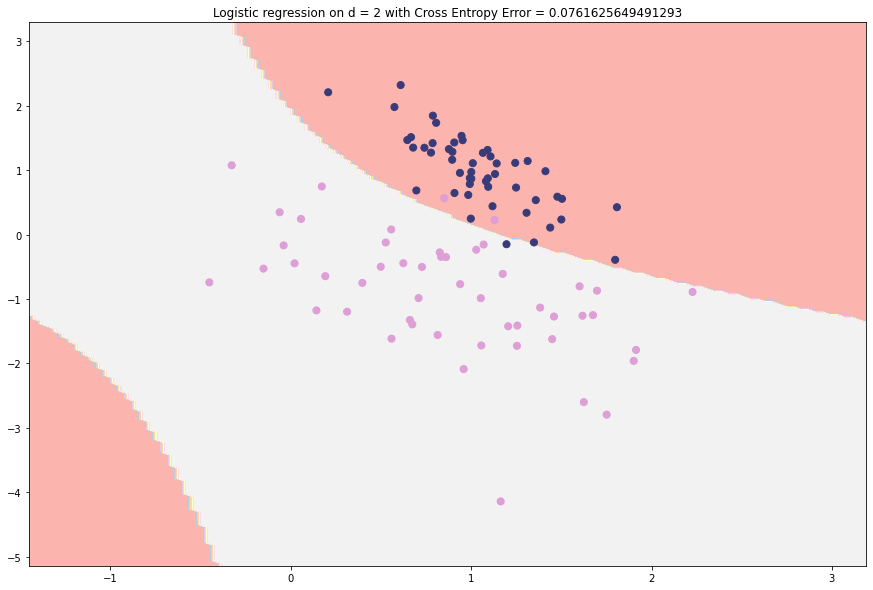

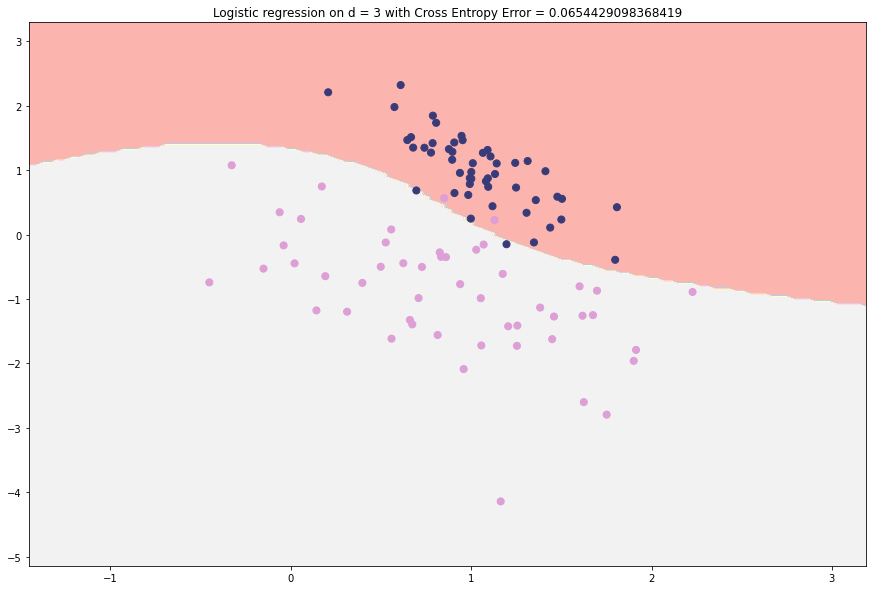

In [31]:
X, y = make_classification(n_features=2, n_classes=2, n_clusters_per_class=1, n_redundant=0)
for d in (2, 3):
    X_tmp = PolynomialFeatures(d).fit_transform(X)
    model = LogisticRegression(C=10).fit(X_tmp, y)
    probs = model.predict_proba(X_tmp)
    ce_error = log_loss(y, probs)
    plot_2d_clf_problem(X, y, lambda X: model.predict(PolynomialFeatures(d).fit_transform(X)),
                   "Logistic regression on d = {} with Cross Entropy Error = {}".format(d, ce_error))

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?